1
Opening file  MCM_APINENE.eqn.txt for parsing
Calculating total number of equations =  843
Parsing each equation
Total number of species =  306
Saving all equation information to dictionaries
2
Mapping species names to SMILES and Pybel objects
No SMILES entry for species  NO3
No SMILES entry for species  CO
No SMILES entry for species  H2
No SMILES entry for species  HNO3
No SMILES entry for species  NO
No SMILES entry for species  NO2
No SMILES entry for species  SO2
No SMILES entry for species  SO3
No SMILES entry for species  H2O2
Calculating properties that dictate gas-to-particle partitioning
Calculating component properties using UManSysProp
Saving the mechanism and property dictionaries as a pickled object for later retrieval
Converting rate coefficient operation into Fortran file
Compiling rate coefficient file using f2py
Creating Fortran file to calculate reactant contribution to equation
Compiling reactant product file using f2py
Creating Fortran file to calculate dy_dt for

/opt/conda/lib/python3.8/site-packages/assimulo/solvers/odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order


Importing pre-compiled Fortran modules
Starting simulation
Final Run Statistics: MCM_APINENE 

 Number of steps                                 : 140
 Number of function evaluations                  : 166
 Number of Jacobian evaluations                  : 5
 Number of function eval. due to Jacobian eval.  : 14255
 Number of error test failures                   : 1
 Number of nonlinear iterations                  : 165
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 0.01
 Tolerances (relative)    : 0.0001

Simulation interval    : 0.0 - 300.0 seconds.
Elapsed simulation time: 186.28451537899673 seconds.
SOA [micrograms/m3] =  0.038243916151718335
Final Run Statistics: MCM_APINENE 

 Number of steps                                 : 29
 Number of function evaluations        

Final Run Statistics: MCM_APINENE 

 Number of steps                                 : 17
 Number of function evaluations                  : 21
 Number of Jacobian evaluations                  : 1
 Number of function eval. due to Jacobian eval.  : 2851
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 20
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 0.01
 Tolerances (relative)    : 0.0001

Simulation interval    : 0.0 - 300.0 seconds.
Elapsed simulation time: 102.80381544800184 seconds.
SOA [micrograms/m3] =  11.687848412806519
Saving the model output as a pickled object for later retrieval


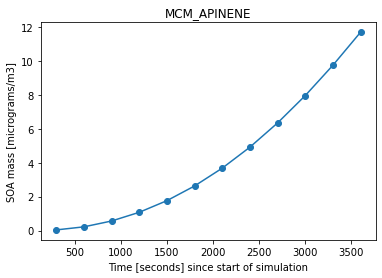

In [4]:
##########################################################################################
#                                                                                        #
#    Example aerosol phase model [gas+condensed phase]. This takes an equation file,     #
#    given in the KPP format,                                                            #
#    and then sets up an ODE solver where initial concentrations of any specie can       #
#    be set. It also relies on some pre-defined rate coefficients and photolysis rates   #
#    taken from the MCM. These are explicitly written into the relevant  modules         #
#    in the file Parse_eqn_file.write_rate_file_xxx() which is provided with a           #
#    Fortran syntax version of pre-defined rates if that version used [see f2py dir]     #
#                                                                                        #
#                                                                                        #
#    The user specifies a starting size distribution and core material                   #
#    The package UManSysProp is then used to calculate properties that dictate           #
#    gas-to-particle partitioning. For feature developments and requests, please see     #
#    the project wiki.                                                                   #
#                                                                                        #
#                                                                                        #
#    Mixed Python - Fortran version. This version uses the f2py module to re-write       #
#    the RHS calculations to exploit multi-core shared/distributed memory machine        #
#                                                                                        #
#                                                                                        #
#    Copyright (C) 2018  David Topping : david.topping@manchester.ac.uk                  #
#                                      : davetopp80@gmail.com                            #
#    Personal website: davetoppingsci.com                                                #
#                                                                                        #
#    All Rights Reserved.                                                                #
#    This file is part of PyBox.                                                         #
#                                                                                        #
#    PyBox is free software: you can redistribute it and/or modify it under              #
#    the terms of the GNU General Public License as published by the Free Software       #
#    Foundation, either version 3 of the License, or (at your option) any later          #
#    version.                                                                            #
#                                                                                        #
#    PyBox is distributed in the hope that it will be useful, but WITHOUT                #
#    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS       #
#    FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more              #
#    details.                                                                            #
#                                                                                        #
#    You should have received a copy of the GNU General Public License along with        #
#    PyBox.  If not, see <http://www.gnu.org/licenses/>.                                 #
#                                                                                        #
##########################################################################################
# Developed using the Anaconda Python 3 distribution and with the Assimulo ODE solver    # 
# suite: http://www.jmodelica.org/assimulo                                               #
# In the import statements, all files developed specifically for this project            #
# as marked [•]                                                                          #
##########################################################################################
                                                                                     
import numpy 
import os, sys
sys.path.append('/home/jovyan/work/PyBox/')
sys.path.append('/home/jovyan/work/PyBox/Aerosol/')
sys.path.append('/home/jovyan/work/UManSysProp_public/')
sys.path.append('/home/jovyan/work/UManSysProp_public/umansysprop')

import Parse_eqn_file # [•] Needed to parse the .eqn file, name given in this file
import rate_coeff_conversion # [•] Converts standard text rate coefficients into Numba/Fortran
import Size_distributions # [•] Create size distribution according to number of bins and core-material
import collections
import pdb
from datetime import datetime
import time
#from ODE_solver_opsplit import run_simulation # [•] Contains routines to run ODE solver
from ODE_solver import run_simulation # [•] Contains routines to run ODE solver
import Property_calculation
import pickle
# You will also need the UManSysProp package and need to change the directory location of that package
# This code relies on UManSysProp to calculate properties - change the link below to where your copy of UManSysProp_public is stored
import openbabel
from shutil import copy2
            
# Start of the main body of code
if __name__=='__main__':
   
    #-------------------------------------------------------------------------------------
    #1)Define starting ambient conditions and species concentrations
    #-------------------------------------------------------------------------------------
    temp=288.15
    RH=0.5 #RH/100%
    PInit=98000 #Pascals - Starting pressure of parcel expansion [if run in Parcel model mode]
    #Define a start time 
    hour_of_day=12.0
    start_time=hour_of_day*60*60 # seconds, used as t0 in solver
    simulation_time= 3600.0 # seconds
    batch_step=300.0 # seconds
    #Convert RH to concentration of water vapour molecules [this will change when in Parcel model mode]
    temp_celsius=temp-273.15
    # Saturation VP of water vapour, to get concentration of H20
    Psat=610.78*numpy.exp((temp_celsius/(temp_celsius+238.3))*17.2694)
    Pw=RH*Psat
    Updraft=0.0
    Wconc=0.002166*(Pw/(temp_celsius+273.16)) #kg/m3
    #Convert from m3 to cm3
    Wconc=Wconc*1.0e-6
    #Convert from kg to molecules/cc
    H2O=Wconc*(1.0/(18.0e-3))*6.0221409e+23
    
    #-------------------------------------------------------------------------------------
    #2) General aerosol partitioning constants
    #-------------------------------------------------------------------------------------
    Lv_water_vapour=2.5e3 # Latent heat of vapourisation of water [J/g] 
    Rv=461.0 #Individual gas constant of water vapour [J/Kg.K]
    Ra=287.0 #Gas constant for dry air [J/Kg.K]
    R_gas=8.3144598 #Ideal gas constant [kg m2 s-2 K-1 mol-1]
    R_gas_other=8.2057e-5 #Ideal gas constant [m3 bar K-1 mol-1]
    GRAV=9.8; #Gravitational acceleration [(m/2)2]
    cp=1005; #Specific heat capacity of air [J/Kg.K]
    sigma=72.0e-3 # Assume surface tension of water (mN/m)
    NA=6.0221409e+23 #Avogadros number
    kb=1.380648E-23 #Boltzmanns constant
    
    #-------------------------------------------------------------------------------------
    # 3) Choose methods used for calculating properties that dictate gas-to-particle partitioning
    #-------------------------------------------------------------------------------------
    # The default are set below, with options given 
    # More information on each method can be found on the UManSysProp website and/or the source code
    vp_method='nannoolal' # Saturation vapour pressure ['nannoolal': 'myrdal_and_yalkowsky': 'evaporation']
    bp_method='joback_and_reid' # Boiling point ['joback_and_reid': 'stein_and_brown': 'nannoolal']    
    critical_method='nannoolal' # Critical properties for density ['nannoolal':'joback_and_reid']
    density_method='girolami' # Pure component liquid density ['girolami': 'schroeder':'le_bas':'tyn_and_calus']
    # Some species will have no vapour pressure data associaed with them by using the .xml file. This
    # includes oxidants. These are then ignored in the partitioning calculations. In addtion, you
    # can also define a calulated vapour pressure above which partitioning can be ignored. This should
    # be set to a relatively high value, given calculated values are given in Log10(atmospehres). By doing this you
    # can significantly decrease the size of of the resultant jacobian and speed-up calculations
    # This information is compiled in the call to Property_calculation.Pure_component1
    ignore_vp=True
    vp_cutoff=-6.0
    
    #-------------------------------------------------------------------------------------
    # 4) Parse equation file 
    #-------------------------------------------------------------------------------------
    # Do files already exist? If so, you can bypass this stage and proceed with simulation
    # Note, this is for you to manage. If unsure which files are available, re-parse and re-compile
    # This is important since the species-2-dict array maps extracted species to array numbers. This
    # can change with each parse
    
    # First we load the files that deal only with the gas phase mechanism

    filename='MCM_APINENE'    

    files_exist = False
    
    if files_exist is False:

        # Delete any 'straggling' f90 or cython files
        for fname in os.listdir('.'):
            #if "f2py.cpython" in fname:
            #    os.remove(fname)
            if ".f90" in fname:
                os.remove(fname)
                
        for fname in os.listdir('.'):
            if ".npy" in fname:
                os.remove(fname)
            if ".pickle" in fname:
                os.remove(fname)
            if ".npz" in fname:
                os.remove(fname)
            if ".eqn.txt" in fname:
                os.remove(fname)

        # Copy mechanism file into working directory
        copy2('/home/jovyan/work/PyBox/mechanism_files/'+filename+'.eqn.txt','.')
                
        # Parse equation file and store relevant dictionaries for later retrieval
        print_options=dict()
        print_options['Full_eqn']=0 #Set to 1 to print details of all equations and rate coefficients parsed [useful for checking]
        print ("1")
        # Define the .eqn file to be used in the following
        outputdict=Parse_eqn_file.extract_mechanism(filename+'.eqn.txt',print_options)
        print ("2")
        
        # Now map these species onto SMILES according to the relevant .xml file that comes with the MCM. If this file changes
        # you will need to change the reference here
        outputdict=Parse_eqn_file.extract_smiles_species(outputdict,'../MCM.xml')

        # Collect the dictionaries generated
        #reaction_dict=outputdict['reaction_dict']
        rate_dict=outputdict['rate_dict']
        rate_dict_fortran=rate_coeff_conversion.convert_rate_mcm_fortran(rate_dict)
        rate_dict_reactants=outputdict['rate_dict_reactants']
        #rate_def=outputdict['rate_def']
        loss_dict=outputdict['loss_dict']
        gain_dict=outputdict['gain_dict']
        stoich_dict=outputdict['stoich_dict']
        species_dict=outputdict['species_dict']
        species_dict2array=outputdict['species_dict2array']
        equations=outputdict['max_equations']
        Pybel_object_dict=outputdict['Pybel_object_dict'] # Might be different size to mechanism extracted dicts [due to ignoring oxidants etc]
        SMILES_dict=outputdict['SMILES_dict']
        num_species=len(species_dict.keys())
        
        # Now calculate all properties that dictate gas-to-particle partitioning
        print("Calculating properties that dictate gas-to-particle partitioning")
        property_dict1=Property_calculation.Pure_component1(num_species,species_dict,
            species_dict2array,Pybel_object_dict,SMILES_dict,temp,vp_method,bp_method,
            critical_method,density_method,ignore_vp,vp_cutoff)
        
        #pdb.set_trace()
        print("Saving the mechanism and property dictionaries as a pickled object for later retrieval")
        # save the dictionary to a file for later retrieval - have to do each seperately.
        with open(filename+'_species_dict2array.pickle', 'wb') as handle:
            pickle.dump(species_dict2array, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(filename+'_species_dict.pickle', 'wb') as handle:
            pickle.dump(species_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        #with open(filename+'_Pybel_object_dict.pickle', 'wb') as handle:
        #    pickle.dump(Pybel_object_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(filename+'_SMILES_dict.pickle', 'wb') as handle:
            pickle.dump(SMILES_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        #with open(filename+'_property_dict1.pickle', 'wb') as handle:
        #    pickle.dump(property_dict1, handle, protocol=pickle.HIGHEST_PROTOCOL)
        #with open(filename+'_property_dict2.pickle', 'wb') as handle:
        #    pickle.dump(property_dict2, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(filename+'_num_species_gas.pickle', 'wb') as handle:
            pickle.dump(num_species, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        # Generate some static Fortran libraries for use in ODE solver
        # Here you have the option to use OpenMP for spreading caclualtions across available cores
        openMP=False
        # Please note, this has not yet been optimised and remains experimental. The default is to
        # not use OpenMP but keep the 'flag' in response to a fully profiled and optimised model version
    
        #pdb.set_trace()
    
        # Convert the rate coefficient expressions into Fortran commands
        print("Converting rate coefficient operation into Fortran file")
        #rate_dict=rate_coeff_conversion.convert_rate_mcm(rate_dict)
        # Convert rate definitions in original *.eqn.txt file into a form to be used in Fortran
        rate_dict_fortran=rate_coeff_conversion.convert_rate_mcm_fortran(rate_dict)
        Parse_eqn_file.write_rate_file_fortran(filename,rate_dict_fortran,openMP)    
        print("Compiling rate coefficient file using f2py")
        #Parse_eqn_file.write_rate_file(filename,rate_dict,mcm_constants_dict)
        #os.system("python f2py_rate_coefficient.py build_ext --inplace --fcompiler=gfortran")
        os.system('f2py -c -m rate_coeff_f2py Rate_coefficients.f90 --f90flags="-O3 -ffast-math -fopenmp" -lgomp')
        
        # Create Fortran file for calculating prodcts all of reactants for all reactions
        print("Creating Fortran file to calculate reactant contribution to equation")
        Parse_eqn_file.write_reactants_indices_fortran(filename,equations,species_dict2array,rate_dict_reactants,loss_dict,openMP)
        print("Compiling reactant product file using f2py")
        #os.system("python f2py_reactant_conc.py build_ext --inplace --fcompiler=gfortran")
        os.system('f2py -c -m reactants_conc_f2py Reactants_conc.f90 --f90flags="-O3 -ffast-math -fopenmp" -lgomp')
        
        # Create Fortran file for calculating dy_dt
        print("Creating Fortran file to calculate dy_dt for each reaction")
        Parse_eqn_file.write_loss_gain_fortran(filename,equations,num_species,loss_dict,gain_dict,species_dict2array,openMP)
        print("Compiling dydt file using f2py")
        #os.system("python f2py_loss_gain.py build_ext --inplace --fcompiler=gfortran")
        os.system('f2py -c -m loss_gain_f2py Loss_Gain.f90 --f90flags="-O3 -ffast-math -fopenmp" -lgomp')
                
        # Create .npy file with indices for all RO2 species
        print("Creating file that holds RO2 species indices")
        Parse_eqn_file.write_RO2_indices(filename,species_dict2array)
        
        # Create jacobian 
        #Parse_eqn_file.write_gas_jacobian_fortran(filename,equations,num_species,loss_dict,gain_dict,species_dict2array,rate_dict_reactants,openMP)
        #print("Compiling jacobian function using f2py")      
        #os.system("python f2py_jacobian.py build_ext --inplace")

    else:
        
        # You have already parsed the .eqn file and stored relevant information. 
        # Load the dictioanties here to pass into the ODE solver
        with open(filename+'_species_dict2array.pickle', 'rb') as f:
            species_dict2array = pickle.load(f) 
        with open(filename+'_species_dict.pickle', 'rb') as f:
            species_dict = pickle.load(f) 
        with open(filename+'_equations.pickle', 'rb') as f:
            equations = pickle.load(f) 
        with open(filename+'_Pybel_object_dict.pickle', 'rb') as f:
            Pybel_object_dict= pickle.load(f) 
        with open(filename+'_SMILES_dict.pickle', 'rb') as f:
            SMILES_dict= pickle.load(f) 
        #with open(filename+'_property_dict1.pickle', 'rb') as f:
        #    property_dict1= pickle.load(f) 
        #with open(filename+'_property_dict2.pickle', 'rb') as f:
        #    property_dict2= pickle.load(f) 
        with open(filename+'_num_species_gas.pickle', 'rb') as f:
            num_species= pickle.load(f) 
            
        print("Calculating properties that dictate gas-to-particle partitioning")
        property_dict1=Property_calculation.Pure_component1(num_species,species_dict,
            species_dict2array,Pybel_object_dict,SMILES_dict,temp,vp_method,bp_method,
            critical_method,density_method,ignore_vp,vp_cutoff)

    #-------------------------------------------------------------------------------------    
    # 5) Modify property arrays to include water as partitioning component
    #-------------------------------------------------------------------------------------
    # Load previously calculated values, and shave off components IF ignore_vp is True
    y_density_array=property_dict1['y_density_array']
    y_mw=property_dict1['y_mw']
    sat_vp=property_dict1['sat_vp']
    Delta_H=property_dict1['Delta_H']
    Latent_heat_gas=property_dict1['Latent_heat_gas']   
    ignore_index=property_dict1['ignore_index'] 
    ignore_index_fortran=property_dict1['ignore_index_fortran'] 
    include_index=sorted(property_dict1['include_index']) # This is an array that captures compounds to be included in the partitioning calculations
    #pdb.set_trace()
    if ignore_vp is True: # Remove those comounds for which there is no vapour pressure data OR are too volatile 
        y_density_array=numpy.array(y_density_array)[include_index].tolist()
        y_mw=numpy.array(y_mw)[include_index].tolist()
        sat_vp=numpy.array(sat_vp)[include_index].tolist()
        Delta_H=numpy.array(Delta_H)[include_index].tolist()
        Latent_heat_gas=numpy.array(Latent_heat_gas)[include_index].tolist()
        
    
    sat_vap_water = numpy.exp((-0.58002206E4 / temp) + 0.13914993E1 - (0.48640239E-1 * temp) + (0.41764768E-4 * (temp**2.0E0))- (0.14452093E-7 * (temp**3.0E0)) + (0.65459673E1 * numpy.log(temp)))
    y_density_array.append(1000.0E0) #Append density of water to array [kg/m3]
    y_mw.append(18.0E0) #Append mw of water to array [g/mol]
    sat_vp.append(numpy.log10(sat_vap_water*9.86923E-6)) #Convert Pa to atm
    Delta_H.append(40.66)
    Latent_heat_gas.append(Lv_water_vapour) #Water vapour, taken from Paul Connolly's parcel model ACPIM
    num_species+=1 #We need to increase the number of species to account for water in the gas phase
    # Now also account for any change in species considered in condensed phase based on those that are ignored
    num_species_condensed=len(y_density_array)
    #Update the Pybel object libraries
    key=openbabel.pybel.readstring('smi','O')
    Pybel_object_dict.update({'O':key})
    #Pybel_object_activity.update({key:Water_Abun})
    species_dict2array.update({'H2O':num_species-1})
    include_index.append(num_species-1)
    #pdb.set_trace()
    ignore_index_fortran=numpy.append(ignore_index_fortran,0.0)
    #pdb.set_trace()
    #-------------------------------------------------------------------------------------
    # 6) Now calculate the additional properties that dictate gas-to-particle partitioning [inc water]
    #-------------------------------------------------------------------------------------
    property_dict2=Property_calculation.Pure_component2(num_species_condensed,y_mw,R_gas,temp)
    alpha_d_org=property_dict2['alpha_d_org']
    DStar_org=property_dict2['DStar_org']
    mean_them_vel=property_dict2['mean_them_vel']
    gamma_gas=property_dict2['gamma_gas']
    
    # Now deal with the files that treat gas-to-particle partitioning
    
    #-------------------------------------------------------------------------------------
    # 7) Define species concetrations     
    #-------------------------------------------------------------------------------------
    # Define initial concentrations, in pbb, of species using names from KPP file
    species_initial_conc=dict()
    species_initial_conc['O3']=18.0
    species_initial_conc['APINENE']=30.0
    #species_initial_conc['BCARY']=20.0

    # Add water
    species_initial_conc['H2O']=H2O

    #-------------------------------------------------------------------------------------
    # 8) Define an initial size distribution. 
    #-------------------------------------------------------------------------------------
    #     This also defines an initial
    #     concentration of core material. This core material can either be
    #     an inert absorptive mass, or have specified SMARTS as organic or
    #     inorganic component. Presently we only have 1 core and it is assumed
    #     involatile.    
    #Please note that the size distribution module has been replicated from
    #http://all-geo.org/volcan01010/2013/09/how-to-use-lognormal-distributions-in-python/
    num_bins=16 #Number of size bins
    y_cond=[0.0]*num_species_condensed*num_bins #array that contains all species in all bins
                                      #water is the final component
    total_conc=100 #Total particles per cc
    std=2.2 #Standard Deviation
    lowersize=0.01 #microns
    uppersize=1.0 #microns
    meansize=0.2 #microns
    #Create a number concentration for a lognormal distribution
    N_perbin,x=Size_distributions.lognormal(num_bins,total_conc,meansize,std,lowersize,uppersize)
    print ("Starting sizes = ", x)
    #Plot the discretized size distribution - Close the figure to proceed
    total_number=sum(N_perbin)

    # - Specify the core material. 
    # This code is currently setup to consider ammonium sulphate as the core
    y_core=[1.0e-3]*num_bins #Will hold concentration of core material, only initialise here [molecules/cc] 
    core_density_array=[1770.0]*num_bins #[kg/m3] - need to make sure this matches core definition above
    core_mw=[132.14]*num_bins #[g/mol]
    #Calculate a concentration, in molecules per cc, per size bin of the involatile material
    #The size bins, 'x', are given in microns. 
    core_type='Inorganic' #Label to be used in non-ideal model variants. It is useful to
    #Define the SMARTS representations of relevant ions for use in proeeding calculations. These can be
    #seleted from the following:
    #[Na+] Sodium cation
    #[NH4+] Ammonium cation
    #[K+] Potassium cation
    #[Ca+2] Calcium cation
    #[Mg+2] Magnesium cation
    #[Cl-] Chloride anion
    #[O-][N+]([O-])=O Nitrate anion
    #[O-]S([O-])(=O)=O Sulphate anion
    key_ion1=openbabel.pybel.readstring('smi','[NH4+]')
    key_ion2=openbabel.pybel.readstring('smi','[O-]S([O-])(=O)=O')
    ammonium_key=key_ion1
    sulphate_key=key_ion2
    #Update the species_dict2array to include the ions
    species_dict2array.update({ammonium_key:num_species})
    species_dict2array.update({sulphate_key:num_species+1})
    cation_index=[0] #used to extract ion concentrations from within the simulation - use order from above [defunct for now]
    anion_index=[1]
    
    core_dissociation=3.0 #Define this according to choice of core type. Please note this value might change
    y_core=(4.0/3.0)*numpy.pi*numpy.power(numpy.array(x*1.0e-6),3.0) #4/3*pi*radius^3
    y_core=y_core*numpy.array(core_density_array) #mass per particle [kg]
    y_core=y_core/(numpy.array(core_mw)*1.0e-3) #moles per particle, changing mw from g/mol to kg/mol
    y_core=y_core*NA #molecules per particle
    y_core=y_core*numpy.array(N_perbin) #molecules/cc representing each size range
    #Calculate a core mass based on the above information [converting from molecules/cc to micrograms/m3]    
    core_mass=numpy.sum(numpy.multiply(numpy.array(y_core)/NA,numpy.array(core_mw)))*1.0E12
    print ("'Dry' core mass = ", core_mass)
    #4) Initialise some water across the distribution according to the starting RH. 
    step=0
    #In the following we need to add water to the last element of every size bin chunk of the array
    for radius in x:
        water_moles=(y_core[step]*core_dissociation)*(RH/(1.0E0-RH))
        y_cond[(num_species_condensed-1)+(step*num_species_condensed)]=water_moles #Add this water to the distribution. 
        #                                                       Note this dosnt yet account for a kelvin factor
        step+=1
        
    #-------------------------------------------------------------------------------------
    # 9) Create partitioning module if it dosnt exist
    # IMPORTANT - if you change the number of size bins this needs re-compiling
    #-------------------------------------------------------------------------------------
    if files_exist is False: # This needs to be changed if either num_species OR num_bins changes
                             # Future versions should add ability to only change number of bins

        # Create a Fortran file for calculating gas-to-particle partitioning drivers
        print("Creating Fortran file to calculate gas-to-particle partitining for each compound")
        Parse_eqn_file.write_partitioning_section_fortran_ignore(num_species+num_species_condensed*num_bins,num_bins,num_species,num_species_condensed,include_index)
        print("Compiling gas-to-particle partitioning file using f2py")
        #os.system("python f2py_partition.py build_ext --inplace --fcompiler=gfortran")    
        os.system('f2py -c -m partition_f2py Partitioning.f90 --f90flags="-O3 -ffast-math -fopenmp" -lgomp')

    #-------------------------------------------------------------------------------------
    # 10) Save this information to a dictionary to pass to ODE solver
    #-------------------------------------------------------------------------------------
    
    input_dict=dict()
    input_dict['species_dict']=species_dict
    input_dict['species_dict2array']=species_dict2array
    input_dict['species_initial_conc']=species_initial_conc
    input_dict['equations']=equations
    input_dict['num_species']=num_species
    input_dict['num_species_condensed']=num_species_condensed
    input_dict['y_density_array_asnumpy']=numpy.array(y_density_array)
    input_dict['y_mw']=numpy.array(y_mw)
    input_dict['sat_vp']=sat_vp
    input_dict['Delta_H']=Delta_H
    input_dict['Latent_heat_asnumpy']=numpy.array(Latent_heat_gas)
    input_dict['DStar_org_asnumpy']=numpy.array(DStar_org)
    input_dict['alpha_d_org_asnumpy']=numpy.array(alpha_d_org)
    input_dict['gamma_gas_asnumpy']=numpy.array(gamma_gas)
    input_dict['Updraft']=Updraft
    input_dict['GRAV']=GRAV
    input_dict['Rv']=Rv
    input_dict['Ra']=Ra
    input_dict['R_gas']=R_gas
    input_dict['R_gas_other']=R_gas_other
    input_dict['cp']=cp
    input_dict['sigma']=sigma
    input_dict['NA']=NA
    input_dict['kb']=kb
    input_dict['Lv_water_vapour']=Lv_water_vapour
    input_dict['ignore_index']=ignore_index
    input_dict['ignore_index_fortran']=ignore_index_fortran
    input_dict['ycore_asnumpy']=numpy.array(y_core)
    input_dict['core_density_array_asnumpy']=numpy.array(core_density_array)
    input_dict['y_cond_initial']=y_cond
    input_dict['num_bins']=num_bins
    input_dict['core_molw_asnumpy']=numpy.array(core_mw)
    input_dict['core_dissociation']=core_dissociation
    input_dict['N_perbin']=N_perbin
    input_dict['include_index']=include_index
    
    RO2_indices=numpy.load(filename+'_RO2_indices.npy')    
    
    #pdb.set_trace()

    #Do you want to save the output from the simulation as a .npy file?
    save_output=True
    plot_mass=True
    print ("OK")
    #-------------------------------------------------------------------------------------
    # 11) Run the simulation
    run_simulation(filename, save_output, start_time, temp, RH, RO2_indices, H2O, PInit, y_cond, input_dict, simulation_time, batch_step, plot_mass)
    #-------------------------------------------------------------------------------------
    

